In [209]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import concatenate
from math import sqrt
import csv, os, random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
%matplotlib inline

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(37)
random.seed(17)

root = '/Users/schwalmdaniel/github/kaggle/multivariate_time_series'

original=pd.read_csv(root + "/PRSA_data_2010.1.1-2014.12.31.csv")
original.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [210]:
original.isna().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2043
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [211]:
original = pd.get_dummies(original, columns = ['cbwd'], prefix_sep='__')
#original['date'] = original['year'].astype(str) + '-' + original['month'].astype(str) \
#    + '-' + original['day'].astype(str) + '-' + original['hour'].astype(str)

original = original.drop(['year','month','day','hour','No'],axis=1)
original['PRES'] = original['PRES'] / 1000.0
original.fillna(original['pm2.5'].mean(),inplace=True)





In [212]:
values = original.values

scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
values

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.        , 1.        ,
        0.        ],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.        , 1.        ,
        0.        ],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 1.        , 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 1.        , 0.        ,
        0.        ],
       [0.01207243, 0.27941176, 0.26229508, ..., 1.        , 0.        ,
        0.        ]])

In [213]:
n_lookback_hours = 1
reframed = series_to_supervised(values, n_lookback_hours, 1)
# TODO: calculate and not hardcode 12
reframed.drop(reframed.columns[12:], axis=1, inplace=True)
reframed.head()

# split into train and test sets
values = reframed.values
n_train_hours = 3 * 365 * 24
# : - means all elements
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# :, :-1 - all rows, all columns except the last one - the features
# :, -1 - all rows, only the last one - the label
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lookback_hours, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], n_lookback_hours, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(26280, 1, 11) (26280,) (17519, 1, 11) (17519,)


Train on 26280 samples, validate on 17519 samples
Epoch 1/100
 - 6s - loss: 0.0323 - val_loss: 0.0376
Epoch 2/100
 - 3s - loss: 0.0143 - val_loss: 0.0169
Epoch 3/100
 - 3s - loss: 0.0136 - val_loss: 0.0162
Epoch 4/100
 - 3s - loss: 0.0138 - val_loss: 0.0144
Epoch 5/100
 - 3s - loss: 0.0137 - val_loss: 0.0139
Epoch 6/100
 - 3s - loss: 0.0137 - val_loss: 0.0138
Epoch 7/100
 - 3s - loss: 0.0137 - val_loss: 0.0150
Epoch 8/100
 - 3s - loss: 0.0136 - val_loss: 0.0142
Epoch 9/100
 - 3s - loss: 0.0136 - val_loss: 0.0158
Epoch 10/100
 - 3s - loss: 0.0136 - val_loss: 0.0143
Epoch 11/100
 - 3s - loss: 0.0137 - val_loss: 0.0176
Epoch 12/100
 - 3s - loss: 0.0136 - val_loss: 0.0167
Epoch 13/100
 - 3s - loss: 0.0136 - val_loss: 0.0155
Epoch 14/100
 - 3s - loss: 0.0136 - val_loss: 0.0165
Epoch 15/100
 - 3s - loss: 0.0136 - val_loss: 0.0157
Epoch 16/100
 - 3s - loss: 0.0136 - val_loss: 0.0147
Epoch 17/100
 - 3s - loss: 0.0134 - val_loss: 0.0142
Epoch 18/100
 - 3s - loss: 0.0135 - val_loss: 0.0151
Epoch

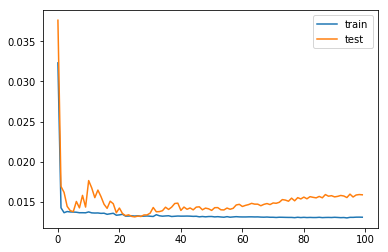

In [216]:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [217]:

yhat = model.predict(test_X)
test_XX = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_XX[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_yy = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_yy, test_XX[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.683
